# ACS2 in Maze
This notebook presents how to integrate ACS2 algorithm with maze environment (using OpenAI Gym interface).

Begin with attaching required dependencies. Because most of the work is by now done locally no PIP modules are used (just pure OS paths)

In [52]:
%matplotlib inline

# General
from __future__ import unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Logger
import logging
logging.basicConfig(level=logging.INFO)

# ALCS + Maze environment
import sys
sys.path.append('/Users/khozzy/Projects/pyalcs')
sys.path.append("/Users/khozzy/Projects/openai-maze-envs")

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from alcs import ACS2, ACS2Configuration
from alcs.acs2 import ClassifiersList

# Load environments
import gym
import gym_maze

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Environment - Maze
We are going to look at provided mazes. Their names starts with "_Maze..._" so see what is possible to load:

In [2]:
all_envs = [env for env in gym.envs.registry.all()]
maze_envs = [env for env in all_envs if env.id.startswith("Maze")]

for env in maze_envs:
    print("Maze ID: [{}], non-deterministic: [{}], trials: [{}]".format(
            env.id, env.nondeterministic, env.trials))

Maze ID: [MazeF1-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF2-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF3-v0], non-deterministic: [False], trials: [100]
Maze ID: [MazeF4-v0], non-deterministic: [True], trials: [100]
Maze ID: [Maze5-v0], non-deterministic: [True], trials: [100]


Let's see how it looks in action. First we are going to initialize new environment using `gym.make()` instruction from OpenAI Gym.

In [3]:
MAZE = "MazeF3-v0"

# Initialize environment
maze = gym.make(MAZE)

# Reset it, by putting an agent into random position
situation = maze.reset()

# Render the state in ASCII
maze.render()

INFO:gym.envs.registration:Making new env: MazeF3-v0



■ ■ ■ ■ ■ ■
■ □ □ □ $ ■
■ □ ■ ■ ■ ■
■ □ □ □ ■ ■
■ A ■ ■ ■ ■
■ ■ ■ ■ ■ ■


The `reset()` function puts an agent into random position (on path inside maze) returning current perception.

> The perception consists of 8 values representing N, NE, E, SE, S, SW, W, NW directions. It outputs 0 for the path, 1 for the wall and 9 for the reward.

In [4]:
# Show current agents perception
situation

('0', '0', '1', '1', '1', '1', '1', '1')

We can interact with the environment by performing actions.

> Agent can perform 8 actions - moving into different directions.

To do so use `step(action)` function. It will return couple interesting information:
- new state percepton,
- reward for executing move (ie. finding the reward)
- is the trial finish,
- debug data

In [5]:
ACTION = 0 # Move N

# Execute action
state, reward, done, _ = maze.step(ACTION)

# Show new state
print("New state: {}, reward: {}, is done: {}".format(state, reward, done))

# Render the env one more time after executing step
maze.render()

New state: ('0', '1', '0', '1', '0', '1', '1', '1'), reward: 0, is done: False

■ ■ ■ ■ ■ ■
■ □ □ □ $ ■
■ □ ■ ■ ■ ■
■ A □ □ ■ ■
■ □ ■ ■ ■ ■
■ ■ ■ ■ ■ ■


## Agent - ACS2
First provide a helper method for calculating obtained knowledge

In [9]:
def calculate_knowledge(maze, population):
    transitions = maze.env.get_all_possible_transitions()

    # Take into consideration only reliable classifiers
    reliable_classifiers = [c for c in population if c.is_reliable()]

    # Count how many transitions are anticipated correctly
    nr_correct = 0

    # For all possible destinations from each path cell
    for start, action, end in transitions:
        p0 = maze.env.maze.perception(*start)
        p1 = maze.env.maze.perception(*end)

        if any([True for cl in reliable_classifiers
                if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return {
        'knowledge': nr_correct / len(transitions) * 100.0
    }

### Exploration phase

In [22]:
CLASSIFIER_LENGTH=8
NUMBER_OF_POSSIBLE_ACTIONS=8

# Define agent's default configuration
cfg = ACS2Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    performance_fcn=calculate_knowledge)

# Define agent
agent = ACS2(cfg)

# Exploration phase
maze.reset()
population, metrics = agent.explore(maze, 10)

INFO:root:{'agent': {'population': 20, 'numerosity': 20, 'reliable': 0, 'fitness': 0.21712794042553182, 'trial': 0, 'steps': 50, 'total_steps': 50}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 28, 'numerosity': 28, 'reliable': 0, 'fitness': 1.8741313934674355, 'trial': 1, 'steps': 12, 'total_steps': 62}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 46, 'numerosity': 46, 'reliable': 0, 'fitness': 3.952479734005815, 'trial': 2, 'steps': 45, 'total_steps': 107}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 62, 'numerosity': 62, 'reliable': 0, 'fitness': 6.589606270085856, 'trial': 3, 'steps': 50, 'total_steps': 157}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 68, 'numerosity': 68, 'reliable': 1, 'fitness': 7.3928392802652425, 'trial': 4, 'steps': 50, 'total_steps': 207}, 'environment': None, 'performance'

We can take a sneak peek into a created list of classifiers. Let's have a look at top 10:

In [20]:
population.sort(key=lambda cl: -cl.fitness)

for cl in population[:10]:
    print("{!r} \tq: {:.2f} \tr: {:.2f} \tir: {:.2f}".format(cl, cl.q, cl.r, cl.ir))

##9#####-2-##1##### @ 0x10b87b6a0 	q: 1.00 	r: 989.05 	ir: 989.04
##0##0#1-2-##9##1## @ 0x10b9007b8 	q: 0.99 	r: 865.85 	ir: 0.00
0010011#-1-1101100# @ 0x10b931860 	q: 0.98 	r: 614.81 	ir: 0.00
######0#-4-######## @ 0x10b8fb198 	q: 1.00 	r: 557.75 	ir: 0.00
####1###-4-######## @ 0x10b900c18 	q: 1.00 	r: 556.23 	ir: 0.00
##9#####-4-######## @ 0x10b925048 	q: 0.80 	r: 496.31 	ir: 0.00
1#######-0-######## @ 0x109a7e128 	q: 1.00 	r: 393.89 	ir: 0.00
#####1##-5-######## @ 0x10b91f4a8 	q: 0.99 	r: 394.91 	ir: 0.00
######0#-0-######## @ 0x10b91fa20 	q: 0.97 	r: 395.72 	ir: 0.00
1###1###-0-######## @ 0x10b91f9e8 	q: 0.97 	r: 395.72 	ir: 0.00


### Exploitation

Now we can either reuse our previous agent or initialize it one more time passing the initial population of classifiers as *apriori* knowledge.

In [24]:
# Reinitialize agent using defined configuration and population
agent = ACS2(cfg, population)

# Reset the environment
maze.reset()
population, metrics = agent.exploit(maze, 1)

INFO:root:{'agent': {'population': 76, 'numerosity': 76, 'reliable': 7, 'fitness': 9.898387042932784, 'trial': 0, 'steps': 50, 'total_steps': 50}, 'environment': None, 'performance': {'knowledge': 9.523809523809524}}


In [25]:
metrics[0:3]

[{'agent': {'fitness': 9.898387042932784,
   'numerosity': 76,
   'population': 76,
   'reliable': 7,
   'steps': 50,
   'total_steps': 50,
   'trial': 0},
  'environment': None,
  'performance': {'knowledge': 9.523809523809524}}]

## Experiments

In [145]:
maze = gym.make('Maze5-v0')

TRIALS_EXPLORE = 3000
TRIALS_EXPLOIT = 200

# explore
agent = ACS2(cfg)
population_explore, metrics_explore = agent.explore(maze, TRIALS_EXPLORE)

# exploit
agent = ACS2(cfg, population_explore)
population_exploit, metrics_exploit = agent.exploit(maze, TRIALS_EXPLOIT)

INFO:gym.envs.registration:Making new env: Maze5-v0
INFO:root:{'agent': {'population': 22, 'numerosity': 22, 'reliable': 0, 'fitness': 0.23472462364863675, 'trial': 0, 'steps': 50, 'total_steps': 50}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 38, 'numerosity': 38, 'reliable': 0, 'fitness': 2.617943757067684, 'trial': 1, 'steps': 26, 'total_steps': 76}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 56, 'numerosity': 56, 'reliable': 0, 'fitness': 2.9663614664127733, 'trial': 2, 'steps': 50, 'total_steps': 126}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 85, 'numerosity': 85, 'reliable': 0, 'fitness': 2.559360521972575, 'trial': 3, 'steps': 50, 'total_steps': 176}, 'environment': None, 'performance': {'knowledge': 0.0}}
INFO:root:{'agent': {'population': 100, 'numerosity': 100, 'reliable': 1, 'fitness': 2.359446679443502, 'trial': 4, 'steps': 50, 't

INFO:root:{'agent': {'population': 346, 'numerosity': 346, 'reliable': 51, 'fitness': 2.622653699985916, 'trial': 37, 'steps': 50, 'total_steps': 1876}, 'environment': None, 'performance': {'knowledge': 15.068493150684931}}
INFO:root:{'agent': {'population': 349, 'numerosity': 349, 'reliable': 53, 'fitness': 2.623159634880776, 'trial': 38, 'steps': 50, 'total_steps': 1926}, 'environment': None, 'performance': {'knowledge': 15.753424657534246}}
INFO:root:{'agent': {'population': 346, 'numerosity': 346, 'reliable': 53, 'fitness': 2.650360477649168, 'trial': 39, 'steps': 50, 'total_steps': 1976}, 'environment': None, 'performance': {'knowledge': 15.753424657534246}}
INFO:root:{'agent': {'population': 350, 'numerosity': 350, 'reliable': 56, 'fitness': 2.6670042462495642, 'trial': 40, 'steps': 50, 'total_steps': 2026}, 'environment': None, 'performance': {'knowledge': 16.43835616438356}}
INFO:root:{'agent': {'population': 350, 'numerosity': 350, 'reliable': 58, 'fitness': 2.6722965611702456

INFO:root:{'agent': {'population': 413, 'numerosity': 413, 'reliable': 83, 'fitness': 3.7326038710860474, 'trial': 74, 'steps': 50, 'total_steps': 3663}, 'environment': None, 'performance': {'knowledge': 26.027397260273972}}
INFO:root:{'agent': {'population': 413, 'numerosity': 413, 'reliable': 83, 'fitness': 3.7227535796533546, 'trial': 75, 'steps': 50, 'total_steps': 3713}, 'environment': None, 'performance': {'knowledge': 26.027397260273972}}
INFO:root:{'agent': {'population': 412, 'numerosity': 412, 'reliable': 84, 'fitness': 3.7283617370439286, 'trial': 76, 'steps': 50, 'total_steps': 3763}, 'environment': None, 'performance': {'knowledge': 26.71232876712329}}
INFO:root:{'agent': {'population': 413, 'numerosity': 413, 'reliable': 84, 'fitness': 3.8861099130755576, 'trial': 77, 'steps': 5, 'total_steps': 3768}, 'environment': None, 'performance': {'knowledge': 26.71232876712329}}
INFO:root:{'agent': {'population': 412, 'numerosity': 412, 'reliable': 86, 'fitness': 3.890863018795849

INFO:root:{'agent': {'population': 395, 'numerosity': 395, 'reliable': 127, 'fitness': 4.618277489688947, 'trial': 111, 'steps': 50, 'total_steps': 5419}, 'environment': None, 'performance': {'knowledge': 36.3013698630137}}
INFO:root:{'agent': {'population': 395, 'numerosity': 395, 'reliable': 131, 'fitness': 4.618806281384243, 'trial': 112, 'steps': 50, 'total_steps': 5469}, 'environment': None, 'performance': {'knowledge': 37.67123287671233}}
INFO:root:{'agent': {'population': 395, 'numerosity': 395, 'reliable': 134, 'fitness': 4.618349475898269, 'trial': 113, 'steps': 50, 'total_steps': 5519}, 'environment': None, 'performance': {'knowledge': 39.04109589041096}}
INFO:root:{'agent': {'population': 393, 'numerosity': 393, 'reliable': 135, 'fitness': 4.64366701363344, 'trial': 114, 'steps': 50, 'total_steps': 5569}, 'environment': None, 'performance': {'knowledge': 39.04109589041096}}
INFO:root:{'agent': {'population': 393, 'numerosity': 393, 'reliable': 135, 'fitness': 4.6491426533744

INFO:root:{'agent': {'population': 397, 'numerosity': 397, 'reliable': 161, 'fitness': 7.2424905703442795, 'trial': 148, 'steps': 50, 'total_steps': 7044}, 'environment': None, 'performance': {'knowledge': 47.94520547945205}}
INFO:root:{'agent': {'population': 397, 'numerosity': 397, 'reliable': 161, 'fitness': 7.241049506100589, 'trial': 149, 'steps': 50, 'total_steps': 7094}, 'environment': None, 'performance': {'knowledge': 47.94520547945205}}
INFO:root:{'agent': {'population': 397, 'numerosity': 397, 'reliable': 161, 'fitness': 7.384786619095598, 'trial': 150, 'steps': 1, 'total_steps': 7095}, 'environment': None, 'performance': {'knowledge': 47.94520547945205}}
INFO:root:{'agent': {'population': 396, 'numerosity': 396, 'reliable': 162, 'fitness': 7.3902346030177695, 'trial': 151, 'steps': 50, 'total_steps': 7145}, 'environment': None, 'performance': {'knowledge': 48.63013698630137}}
INFO:root:{'agent': {'population': 399, 'numerosity': 399, 'reliable': 162, 'fitness': 7.5306370239

INFO:root:{'agent': {'population': 397, 'numerosity': 397, 'reliable': 182, 'fitness': 12.373858943837005, 'trial': 185, 'steps': 32, 'total_steps': 8218}, 'environment': None, 'performance': {'knowledge': 54.794520547945204}}
INFO:root:{'agent': {'population': 397, 'numerosity': 397, 'reliable': 182, 'fitness': 12.7986100182627, 'trial': 186, 'steps': 15, 'total_steps': 8233}, 'environment': None, 'performance': {'knowledge': 54.794520547945204}}
INFO:root:{'agent': {'population': 399, 'numerosity': 399, 'reliable': 182, 'fitness': 13.302105538434784, 'trial': 187, 'steps': 12, 'total_steps': 8245}, 'environment': None, 'performance': {'knowledge': 54.794520547945204}}
INFO:root:{'agent': {'population': 399, 'numerosity': 399, 'reliable': 183, 'fitness': 13.710791190836298, 'trial': 188, 'steps': 30, 'total_steps': 8275}, 'environment': None, 'performance': {'knowledge': 55.47945205479452}}
INFO:root:{'agent': {'population': 399, 'numerosity': 399, 'reliable': 183, 'fitness': 14.17194

INFO:root:{'agent': {'population': 393, 'numerosity': 393, 'reliable': 200, 'fitness': 23.854586734645455, 'trial': 222, 'steps': 27, 'total_steps': 9098}, 'environment': None, 'performance': {'knowledge': 58.21917808219178}}
INFO:root:{'agent': {'population': 393, 'numerosity': 393, 'reliable': 201, 'fitness': 24.128591925227084, 'trial': 223, 'steps': 4, 'total_steps': 9102}, 'environment': None, 'performance': {'knowledge': 58.9041095890411}}
INFO:root:{'agent': {'population': 393, 'numerosity': 393, 'reliable': 202, 'fitness': 24.649724841946586, 'trial': 224, 'steps': 5, 'total_steps': 9107}, 'environment': None, 'performance': {'knowledge': 58.9041095890411}}
INFO:root:{'agent': {'population': 393, 'numerosity': 393, 'reliable': 202, 'fitness': 24.751173659454693, 'trial': 225, 'steps': 1, 'total_steps': 9108}, 'environment': None, 'performance': {'knowledge': 58.9041095890411}}
INFO:root:{'agent': {'population': 393, 'numerosity': 393, 'reliable': 202, 'fitness': 25.175757025526

INFO:root:{'agent': {'population': 389, 'numerosity': 389, 'reliable': 218, 'fitness': 36.642049715167474, 'trial': 259, 'steps': 6, 'total_steps': 9794}, 'environment': None, 'performance': {'knowledge': 64.38356164383562}}
INFO:root:{'agent': {'population': 389, 'numerosity': 389, 'reliable': 218, 'fitness': 36.84027019992761, 'trial': 260, 'steps': 3, 'total_steps': 9797}, 'environment': None, 'performance': {'knowledge': 64.38356164383562}}
INFO:root:{'agent': {'population': 389, 'numerosity': 389, 'reliable': 218, 'fitness': 36.80027105964124, 'trial': 261, 'steps': 50, 'total_steps': 9847}, 'environment': None, 'performance': {'knowledge': 64.38356164383562}}
INFO:root:{'agent': {'population': 389, 'numerosity': 389, 'reliable': 220, 'fitness': 37.01671923271146, 'trial': 262, 'steps': 27, 'total_steps': 9874}, 'environment': None, 'performance': {'knowledge': 65.75342465753424}}
INFO:root:{'agent': {'population': 389, 'numerosity': 389, 'reliable': 220, 'fitness': 36.93891220223

INFO:root:{'agent': {'population': 387, 'numerosity': 387, 'reliable': 231, 'fitness': 55.19724580397928, 'trial': 296, 'steps': 10, 'total_steps': 10578}, 'environment': None, 'performance': {'knowledge': 69.86301369863014}}
INFO:root:{'agent': {'population': 387, 'numerosity': 387, 'reliable': 231, 'fitness': 55.65210878136893, 'trial': 297, 'steps': 11, 'total_steps': 10589}, 'environment': None, 'performance': {'knowledge': 69.86301369863014}}
INFO:root:{'agent': {'population': 387, 'numerosity': 387, 'reliable': 231, 'fitness': 56.02507767664609, 'trial': 298, 'steps': 10, 'total_steps': 10599}, 'environment': None, 'performance': {'knowledge': 69.86301369863014}}
INFO:root:{'agent': {'population': 384, 'numerosity': 384, 'reliable': 231, 'fitness': 56.319633590810895, 'trial': 299, 'steps': 42, 'total_steps': 10641}, 'environment': None, 'performance': {'knowledge': 69.86301369863014}}
INFO:root:{'agent': {'population': 384, 'numerosity': 384, 'reliable': 231, 'fitness': 57.21597

INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 235, 'fitness': 75.68168896851174, 'trial': 333, 'steps': 9, 'total_steps': 11036}, 'environment': None, 'performance': {'knowledge': 70.54794520547945}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 235, 'fitness': 76.0517441580426, 'trial': 334, 'steps': 9, 'total_steps': 11045}, 'environment': None, 'performance': {'knowledge': 70.54794520547945}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 235, 'fitness': 76.50736222698849, 'trial': 335, 'steps': 10, 'total_steps': 11055}, 'environment': None, 'performance': {'knowledge': 70.54794520547945}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 235, 'fitness': 77.16950200781476, 'trial': 336, 'steps': 19, 'total_steps': 11074}, 'environment': None, 'performance': {'knowledge': 70.54794520547945}}
INFO:root:{'agent': {'population': 380, 'numerosity': 380, 'reliable': 235, 'fitness': 77.174337091

INFO:root:{'agent': {'population': 374, 'numerosity': 374, 'reliable': 238, 'fitness': 94.15184064115753, 'trial': 370, 'steps': 10, 'total_steps': 11469}, 'environment': None, 'performance': {'knowledge': 71.91780821917808}}
INFO:root:{'agent': {'population': 373, 'numerosity': 373, 'reliable': 238, 'fitness': 95.0244103848566, 'trial': 371, 'steps': 13, 'total_steps': 11482}, 'environment': None, 'performance': {'knowledge': 71.91780821917808}}
INFO:root:{'agent': {'population': 373, 'numerosity': 373, 'reliable': 239, 'fitness': 95.25450240475597, 'trial': 372, 'steps': 6, 'total_steps': 11488}, 'environment': None, 'performance': {'knowledge': 71.91780821917808}}
INFO:root:{'agent': {'population': 373, 'numerosity': 373, 'reliable': 240, 'fitness': 95.7153645999918, 'trial': 373, 'steps': 7, 'total_steps': 11495}, 'environment': None, 'performance': {'knowledge': 72.6027397260274}}
INFO:root:{'agent': {'population': 373, 'numerosity': 373, 'reliable': 240, 'fitness': 95.90530502017

INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 244, 'fitness': 114.12961439292164, 'trial': 407, 'steps': 2, 'total_steps': 11883}, 'environment': None, 'performance': {'knowledge': 73.97260273972603}}
INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 244, 'fitness': 115.16285972278514, 'trial': 408, 'steps': 18, 'total_steps': 11901}, 'environment': None, 'performance': {'knowledge': 73.97260273972603}}
INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 244, 'fitness': 115.82864540637549, 'trial': 409, 'steps': 14, 'total_steps': 11915}, 'environment': None, 'performance': {'knowledge': 73.97260273972603}}
INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 244, 'fitness': 116.204592471334, 'trial': 410, 'steps': 7, 'total_steps': 11922}, 'environment': None, 'performance': {'knowledge': 73.97260273972603}}
INFO:root:{'agent': {'population': 372, 'numerosity': 372, 'reliable': 244, 'fitness': 116.89212

INFO:root:{'agent': {'population': 370, 'numerosity': 370, 'reliable': 249, 'fitness': 135.01364061994894, 'trial': 444, 'steps': 6, 'total_steps': 12292}, 'environment': None, 'performance': {'knowledge': 76.71232876712328}}
INFO:root:{'agent': {'population': 370, 'numerosity': 370, 'reliable': 249, 'fitness': 135.21719987417143, 'trial': 445, 'steps': 6, 'total_steps': 12298}, 'environment': None, 'performance': {'knowledge': 76.71232876712328}}
INFO:root:{'agent': {'population': 370, 'numerosity': 370, 'reliable': 249, 'fitness': 136.5998160815299, 'trial': 446, 'steps': 12, 'total_steps': 12310}, 'environment': None, 'performance': {'knowledge': 76.71232876712328}}
INFO:root:{'agent': {'population': 370, 'numerosity': 370, 'reliable': 250, 'fitness': 136.9656854276679, 'trial': 447, 'steps': 12, 'total_steps': 12322}, 'environment': None, 'performance': {'knowledge': 77.3972602739726}}
INFO:root:{'agent': {'population': 370, 'numerosity': 370, 'reliable': 250, 'fitness': 137.313072

INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 259, 'fitness': 160.10359338217464, 'trial': 481, 'steps': 7, 'total_steps': 12807}, 'environment': None, 'performance': {'knowledge': 80.82191780821918}}
INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 260, 'fitness': 160.9464472280007, 'trial': 482, 'steps': 13, 'total_steps': 12820}, 'environment': None, 'performance': {'knowledge': 81.5068493150685}}
INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 260, 'fitness': 161.92603861836983, 'trial': 483, 'steps': 19, 'total_steps': 12839}, 'environment': None, 'performance': {'knowledge': 81.5068493150685}}
INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 260, 'fitness': 162.04168446015765, 'trial': 484, 'steps': 4, 'total_steps': 12843}, 'environment': None, 'performance': {'knowledge': 81.5068493150685}}
INFO:root:{'agent': {'population': 369, 'numerosity': 369, 'reliable': 260, 'fitness': 162.7540833

INFO:root:{'agent': {'population': 371, 'numerosity': 371, 'reliable': 263, 'fitness': 177.6686293161218, 'trial': 518, 'steps': 7, 'total_steps': 13213}, 'environment': None, 'performance': {'knowledge': 81.5068493150685}}
INFO:root:{'agent': {'population': 371, 'numerosity': 371, 'reliable': 263, 'fitness': 178.68385303200643, 'trial': 519, 'steps': 14, 'total_steps': 13227}, 'environment': None, 'performance': {'knowledge': 81.5068493150685}}
INFO:root:{'agent': {'population': 371, 'numerosity': 371, 'reliable': 263, 'fitness': 178.82280356596385, 'trial': 520, 'steps': 6, 'total_steps': 13233}, 'environment': None, 'performance': {'knowledge': 81.5068493150685}}
INFO:root:{'agent': {'population': 371, 'numerosity': 371, 'reliable': 263, 'fitness': 179.80780588865542, 'trial': 521, 'steps': 40, 'total_steps': 13273}, 'environment': None, 'performance': {'knowledge': 81.5068493150685}}
INFO:root:{'agent': {'population': 371, 'numerosity': 371, 'reliable': 263, 'fitness': 179.82383130

INFO:root:{'agent': {'population': 363, 'numerosity': 363, 'reliable': 273, 'fitness': 203.32407164071773, 'trial': 555, 'steps': 19, 'total_steps': 13769}, 'environment': None, 'performance': {'knowledge': 84.93150684931507}}
INFO:root:{'agent': {'population': 363, 'numerosity': 363, 'reliable': 274, 'fitness': 205.4405704317386, 'trial': 556, 'steps': 24, 'total_steps': 13793}, 'environment': None, 'performance': {'knowledge': 84.93150684931507}}
INFO:root:{'agent': {'population': 363, 'numerosity': 363, 'reliable': 274, 'fitness': 206.51973972155335, 'trial': 557, 'steps': 17, 'total_steps': 13810}, 'environment': None, 'performance': {'knowledge': 84.93150684931507}}
INFO:root:{'agent': {'population': 363, 'numerosity': 363, 'reliable': 274, 'fitness': 206.51982741604712, 'trial': 558, 'steps': 1, 'total_steps': 13811}, 'environment': None, 'performance': {'knowledge': 84.93150684931507}}
INFO:root:{'agent': {'population': 363, 'numerosity': 363, 'reliable': 274, 'fitness': 207.024

INFO:root:{'agent': {'population': 362, 'numerosity': 362, 'reliable': 278, 'fitness': 226.24485900723542, 'trial': 592, 'steps': 26, 'total_steps': 14187}, 'environment': None, 'performance': {'knowledge': 86.98630136986301}}
INFO:root:{'agent': {'population': 362, 'numerosity': 362, 'reliable': 278, 'fitness': 226.3798024731202, 'trial': 593, 'steps': 7, 'total_steps': 14194}, 'environment': None, 'performance': {'knowledge': 86.98630136986301}}
INFO:root:{'agent': {'population': 362, 'numerosity': 362, 'reliable': 278, 'fitness': 227.43710912523565, 'trial': 594, 'steps': 14, 'total_steps': 14208}, 'environment': None, 'performance': {'knowledge': 86.98630136986301}}
INFO:root:{'agent': {'population': 362, 'numerosity': 362, 'reliable': 278, 'fitness': 228.06606754378126, 'trial': 595, 'steps': 9, 'total_steps': 14217}, 'environment': None, 'performance': {'knowledge': 86.98630136986301}}
INFO:root:{'agent': {'population': 362, 'numerosity': 362, 'reliable': 278, 'fitness': 228.4175

INFO:root:{'agent': {'population': 359, 'numerosity': 359, 'reliable': 281, 'fitness': 246.64516188750264, 'trial': 629, 'steps': 13, 'total_steps': 14629}, 'environment': None, 'performance': {'knowledge': 89.04109589041096}}
INFO:root:{'agent': {'population': 359, 'numerosity': 359, 'reliable': 281, 'fitness': 246.7785052333278, 'trial': 630, 'steps': 6, 'total_steps': 14635}, 'environment': None, 'performance': {'knowledge': 89.04109589041096}}
INFO:root:{'agent': {'population': 359, 'numerosity': 359, 'reliable': 281, 'fitness': 248.73055556480543, 'trial': 631, 'steps': 30, 'total_steps': 14665}, 'environment': None, 'performance': {'knowledge': 89.04109589041096}}
INFO:root:{'agent': {'population': 359, 'numerosity': 359, 'reliable': 281, 'fitness': 249.38533772009166, 'trial': 632, 'steps': 14, 'total_steps': 14679}, 'environment': None, 'performance': {'knowledge': 89.04109589041096}}
INFO:root:{'agent': {'population': 359, 'numerosity': 359, 'reliable': 281, 'fitness': 249.907

INFO:root:{'agent': {'population': 357, 'numerosity': 357, 'reliable': 286, 'fitness': 267.59221340179687, 'trial': 666, 'steps': 9, 'total_steps': 15101}, 'environment': None, 'performance': {'knowledge': 89.72602739726028}}
INFO:root:{'agent': {'population': 356, 'numerosity': 356, 'reliable': 286, 'fitness': 271.2898050718398, 'trial': 667, 'steps': 46, 'total_steps': 15147}, 'environment': None, 'performance': {'knowledge': 89.72602739726028}}
INFO:root:{'agent': {'population': 356, 'numerosity': 356, 'reliable': 286, 'fitness': 271.85328663300146, 'trial': 668, 'steps': 12, 'total_steps': 15159}, 'environment': None, 'performance': {'knowledge': 89.72602739726028}}
INFO:root:{'agent': {'population': 356, 'numerosity': 356, 'reliable': 286, 'fitness': 272.24149646237447, 'trial': 669, 'steps': 10, 'total_steps': 15169}, 'environment': None, 'performance': {'knowledge': 89.72602739726028}}
INFO:root:{'agent': {'population': 356, 'numerosity': 356, 'reliable': 286, 'fitness': 272.242

INFO:root:{'agent': {'population': 353, 'numerosity': 353, 'reliable': 286, 'fitness': 289.7126080082325, 'trial': 703, 'steps': 14, 'total_steps': 15560}, 'environment': None, 'performance': {'knowledge': 89.72602739726028}}
INFO:root:{'agent': {'population': 353, 'numerosity': 353, 'reliable': 286, 'fitness': 289.7381027287621, 'trial': 704, 'steps': 4, 'total_steps': 15564}, 'environment': None, 'performance': {'knowledge': 89.72602739726028}}
INFO:root:{'agent': {'population': 353, 'numerosity': 353, 'reliable': 286, 'fitness': 290.6070390035369, 'trial': 705, 'steps': 21, 'total_steps': 15585}, 'environment': None, 'performance': {'knowledge': 89.72602739726028}}
INFO:root:{'agent': {'population': 353, 'numerosity': 353, 'reliable': 286, 'fitness': 291.0567163769613, 'trial': 706, 'steps': 14, 'total_steps': 15599}, 'environment': None, 'performance': {'knowledge': 89.72602739726028}}
INFO:root:{'agent': {'population': 353, 'numerosity': 353, 'reliable': 286, 'fitness': 291.056808

INFO:root:{'agent': {'population': 351, 'numerosity': 351, 'reliable': 290, 'fitness': 307.02464700429385, 'trial': 740, 'steps': 10, 'total_steps': 15998}, 'environment': None, 'performance': {'knowledge': 90.41095890410958}}
INFO:root:{'agent': {'population': 351, 'numerosity': 351, 'reliable': 290, 'fitness': 307.8441851943533, 'trial': 741, 'steps': 17, 'total_steps': 16015}, 'environment': None, 'performance': {'knowledge': 90.41095890410958}}
INFO:root:{'agent': {'population': 351, 'numerosity': 351, 'reliable': 290, 'fitness': 308.1097629540886, 'trial': 742, 'steps': 8, 'total_steps': 16023}, 'environment': None, 'performance': {'knowledge': 90.41095890410958}}
INFO:root:{'agent': {'population': 351, 'numerosity': 351, 'reliable': 290, 'fitness': 308.5965912413498, 'trial': 743, 'steps': 15, 'total_steps': 16038}, 'environment': None, 'performance': {'knowledge': 90.41095890410958}}
INFO:root:{'agent': {'population': 351, 'numerosity': 351, 'reliable': 290, 'fitness': 308.74134

INFO:root:{'agent': {'population': 351, 'numerosity': 351, 'reliable': 294, 'fitness': 322.86531176086686, 'trial': 777, 'steps': 6, 'total_steps': 16412}, 'environment': None, 'performance': {'knowledge': 91.78082191780823}}
INFO:root:{'agent': {'population': 351, 'numerosity': 351, 'reliable': 294, 'fitness': 323.26917045455247, 'trial': 778, 'steps': 12, 'total_steps': 16424}, 'environment': None, 'performance': {'knowledge': 91.78082191780823}}
INFO:root:{'agent': {'population': 351, 'numerosity': 351, 'reliable': 294, 'fitness': 324.85777006440844, 'trial': 779, 'steps': 24, 'total_steps': 16448}, 'environment': None, 'performance': {'knowledge': 91.78082191780823}}
INFO:root:{'agent': {'population': 351, 'numerosity': 351, 'reliable': 294, 'fitness': 324.86726601525663, 'trial': 780, 'steps': 4, 'total_steps': 16452}, 'environment': None, 'performance': {'knowledge': 91.78082191780823}}
INFO:root:{'agent': {'population': 351, 'numerosity': 351, 'reliable': 295, 'fitness': 325.160

INFO:root:{'agent': {'population': 349, 'numerosity': 349, 'reliable': 296, 'fitness': 339.5808463046019, 'trial': 814, 'steps': 1, 'total_steps': 16807}, 'environment': None, 'performance': {'knowledge': 92.46575342465754}}
INFO:root:{'agent': {'population': 348, 'numerosity': 348, 'reliable': 296, 'fitness': 342.0725258163433, 'trial': 815, 'steps': 24, 'total_steps': 16831}, 'environment': None, 'performance': {'knowledge': 92.46575342465754}}
INFO:root:{'agent': {'population': 348, 'numerosity': 348, 'reliable': 296, 'fitness': 342.7631739577225, 'trial': 816, 'steps': 37, 'total_steps': 16868}, 'environment': None, 'performance': {'knowledge': 92.46575342465754}}
INFO:root:{'agent': {'population': 348, 'numerosity': 348, 'reliable': 296, 'fitness': 343.00497078015053, 'trial': 817, 'steps': 10, 'total_steps': 16878}, 'environment': None, 'performance': {'knowledge': 92.46575342465754}}
INFO:root:{'agent': {'population': 348, 'numerosity': 348, 'reliable': 296, 'fitness': 343.29409

INFO:root:{'agent': {'population': 348, 'numerosity': 348, 'reliable': 296, 'fitness': 355.8846713157231, 'trial': 851, 'steps': 10, 'total_steps': 17253}, 'environment': None, 'performance': {'knowledge': 92.46575342465754}}
INFO:root:{'agent': {'population': 348, 'numerosity': 348, 'reliable': 297, 'fitness': 356.4095039368187, 'trial': 852, 'steps': 28, 'total_steps': 17281}, 'environment': None, 'performance': {'knowledge': 93.15068493150685}}
INFO:root:{'agent': {'population': 348, 'numerosity': 348, 'reliable': 297, 'fitness': 356.4664804055477, 'trial': 853, 'steps': 3, 'total_steps': 17284}, 'environment': None, 'performance': {'knowledge': 93.15068493150685}}
INFO:root:{'agent': {'population': 348, 'numerosity': 348, 'reliable': 297, 'fitness': 357.0101353781776, 'trial': 854, 'steps': 24, 'total_steps': 17308}, 'environment': None, 'performance': {'knowledge': 93.15068493150685}}
INFO:root:{'agent': {'population': 348, 'numerosity': 348, 'reliable': 297, 'fitness': 357.600367

INFO:root:{'agent': {'population': 347, 'numerosity': 347, 'reliable': 302, 'fitness': 378.0969839701154, 'trial': 888, 'steps': 17, 'total_steps': 17816}, 'environment': None, 'performance': {'knowledge': 93.83561643835617}}
INFO:root:{'agent': {'population': 347, 'numerosity': 347, 'reliable': 302, 'fitness': 378.1905342187491, 'trial': 889, 'steps': 7, 'total_steps': 17823}, 'environment': None, 'performance': {'knowledge': 93.83561643835617}}
INFO:root:{'agent': {'population': 347, 'numerosity': 347, 'reliable': 302, 'fitness': 378.73307052113444, 'trial': 890, 'steps': 13, 'total_steps': 17836}, 'environment': None, 'performance': {'knowledge': 93.83561643835617}}
INFO:root:{'agent': {'population': 347, 'numerosity': 347, 'reliable': 302, 'fitness': 378.85574295337125, 'trial': 891, 'steps': 8, 'total_steps': 17844}, 'environment': None, 'performance': {'knowledge': 93.83561643835617}}
INFO:root:{'agent': {'population': 347, 'numerosity': 347, 'reliable': 304, 'fitness': 380.36676

INFO:root:{'agent': {'population': 345, 'numerosity': 345, 'reliable': 310, 'fitness': 398.3526332238366, 'trial': 925, 'steps': 5, 'total_steps': 18310}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 345, 'numerosity': 345, 'reliable': 310, 'fitness': 398.85106237062206, 'trial': 926, 'steps': 14, 'total_steps': 18324}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 345, 'numerosity': 345, 'reliable': 310, 'fitness': 399.3079173851118, 'trial': 927, 'steps': 13, 'total_steps': 18337}, 'environment': None, 'performance': {'knowledge': 95.2054794520548}}
INFO:root:{'agent': {'population': 345, 'numerosity': 345, 'reliable': 311, 'fitness': 400.2000042728862, 'trial': 928, 'steps': 26, 'total_steps': 18363}, 'environment': None, 'performance': {'knowledge': 95.8904109589041}}
INFO:root:{'agent': {'population': 345, 'numerosity': 345, 'reliable': 311, 'fitness': 400.580898715

INFO:root:{'agent': {'population': 345, 'numerosity': 345, 'reliable': 313, 'fitness': 411.549049303639, 'trial': 962, 'steps': 19, 'total_steps': 18727}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 345, 'numerosity': 345, 'reliable': 313, 'fitness': 411.8491564864236, 'trial': 963, 'steps': 12, 'total_steps': 18739}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 345, 'numerosity': 345, 'reliable': 313, 'fitness': 412.284726001288, 'trial': 964, 'steps': 11, 'total_steps': 18750}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 345, 'numerosity': 345, 'reliable': 313, 'fitness': 412.43930322062005, 'trial': 965, 'steps': 10, 'total_steps': 18760}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 345, 'numerosity': 345, 'reliable': 313, 'fitness': 412.976559

INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 316, 'fitness': 426.96054879002486, 'trial': 999, 'steps': 11, 'total_steps': 19212}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 316, 'fitness': 427.55174068385395, 'trial': 1000, 'steps': 10, 'total_steps': 19222}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 316, 'fitness': 427.9665097530425, 'trial': 1001, 'steps': 17, 'total_steps': 19239}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 316, 'fitness': 428.41186673289116, 'trial': 1002, 'steps': 22, 'total_steps': 19261}, 'environment': None, 'performance': {'knowledge': 97.26027397260275}}
INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 316, 'fitness': 428

INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 319, 'fitness': 441.5691205115023, 'trial': 1036, 'steps': 18, 'total_steps': 19754}, 'environment': None, 'performance': {'knowledge': 98.63013698630137}}
INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 319, 'fitness': 442.06069428823184, 'trial': 1037, 'steps': 23, 'total_steps': 19777}, 'environment': None, 'performance': {'knowledge': 98.63013698630137}}
INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 320, 'fitness': 442.4476653943848, 'trial': 1038, 'steps': 13, 'total_steps': 19790}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 320, 'fitness': 442.65990392379115, 'trial': 1039, 'steps': 16, 'total_steps': 19806}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 320, 'fitness': 442

INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 320, 'fitness': 450.19777681949853, 'trial': 1073, 'steps': 17, 'total_steps': 20152}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 320, 'fitness': 451.4528036423029, 'trial': 1074, 'steps': 32, 'total_steps': 20184}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 320, 'fitness': 451.996237937194, 'trial': 1075, 'steps': 18, 'total_steps': 20202}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 320, 'fitness': 452.249538108751, 'trial': 1076, 'steps': 6, 'total_steps': 20208}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 320, 'fitness': 452.252

INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 321, 'fitness': 464.84767581822234, 'trial': 1110, 'steps': 5, 'total_steps': 20635}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 321, 'fitness': 465.0217516107914, 'trial': 1111, 'steps': 26, 'total_steps': 20661}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 321, 'fitness': 465.1229634363869, 'trial': 1112, 'steps': 10, 'total_steps': 20671}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 321, 'fitness': 465.21627102720305, 'trial': 1113, 'steps': 9, 'total_steps': 20680}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 344, 'numerosity': 344, 'reliable': 322, 'fitness': 465.8

INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 322, 'fitness': 475.2376874134249, 'trial': 1147, 'steps': 18, 'total_steps': 21126}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 322, 'fitness': 475.38546974176666, 'trial': 1148, 'steps': 10, 'total_steps': 21136}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 322, 'fitness': 475.7587676663155, 'trial': 1149, 'steps': 19, 'total_steps': 21155}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 322, 'fitness': 475.81874136207335, 'trial': 1150, 'steps': 8, 'total_steps': 21163}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 322, 'fitness': 476.

INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 322, 'fitness': 482.94414445399406, 'trial': 1184, 'steps': 13, 'total_steps': 21603}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 322, 'fitness': 483.1911645741095, 'trial': 1185, 'steps': 15, 'total_steps': 21618}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 322, 'fitness': 483.26708603876614, 'trial': 1186, 'steps': 11, 'total_steps': 21629}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 322, 'fitness': 483.3847394359584, 'trial': 1187, 'steps': 12, 'total_steps': 21641}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 322, 'fitness': 483

INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 324, 'fitness': 490.6313958352743, 'trial': 1221, 'steps': 10, 'total_steps': 22003}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 324, 'fitness': 491.54107942804126, 'trial': 1222, 'steps': 33, 'total_steps': 22036}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 324, 'fitness': 491.8526620574155, 'trial': 1223, 'steps': 15, 'total_steps': 22051}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 324, 'fitness': 491.88006380554486, 'trial': 1224, 'steps': 6, 'total_steps': 22057}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 324, 'fitness': 491.

INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 324, 'fitness': 499.6113922052869, 'trial': 1258, 'steps': 9, 'total_steps': 22506}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 324, 'fitness': 500.505618784474, 'trial': 1259, 'steps': 50, 'total_steps': 22556}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 324, 'fitness': 500.5944048386224, 'trial': 1260, 'steps': 23, 'total_steps': 22579}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 324, 'fitness': 500.966167177125, 'trial': 1261, 'steps': 22, 'total_steps': 22601}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 343, 'numerosity': 343, 'reliable': 324, 'fitness': 501.0127

INFO:root:{'agent': {'population': 342, 'numerosity': 342, 'reliable': 324, 'fitness': 509.57868227461256, 'trial': 1295, 'steps': 10, 'total_steps': 23037}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 342, 'numerosity': 342, 'reliable': 324, 'fitness': 509.8438736404826, 'trial': 1296, 'steps': 12, 'total_steps': 23049}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 342, 'numerosity': 342, 'reliable': 324, 'fitness': 509.8953144714827, 'trial': 1297, 'steps': 6, 'total_steps': 23055}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 342, 'numerosity': 342, 'reliable': 324, 'fitness': 509.9699683211535, 'trial': 1298, 'steps': 9, 'total_steps': 23064}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 342, 'numerosity': 342, 'reliable': 324, 'fitness': 509.96

INFO:root:{'agent': {'population': 342, 'numerosity': 342, 'reliable': 324, 'fitness': 519.2349706937774, 'trial': 1332, 'steps': 13, 'total_steps': 23488}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 342, 'numerosity': 342, 'reliable': 324, 'fitness': 519.2727116052444, 'trial': 1333, 'steps': 21, 'total_steps': 23509}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 342, 'numerosity': 342, 'reliable': 324, 'fitness': 519.9301697537555, 'trial': 1334, 'steps': 21, 'total_steps': 23530}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 341, 'numerosity': 341, 'reliable': 324, 'fitness': 521.7220673760598, 'trial': 1335, 'steps': 22, 'total_steps': 23552}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 341, 'numerosity': 341, 'reliable': 324, 'fitness': 522.0

INFO:root:{'agent': {'population': 341, 'numerosity': 341, 'reliable': 325, 'fitness': 531.545208092515, 'trial': 1369, 'steps': 6, 'total_steps': 23982}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 341, 'numerosity': 341, 'reliable': 325, 'fitness': 531.7395139575265, 'trial': 1370, 'steps': 20, 'total_steps': 24002}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 341, 'numerosity': 341, 'reliable': 325, 'fitness': 532.1130868344078, 'trial': 1371, 'steps': 10, 'total_steps': 24012}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 341, 'numerosity': 341, 'reliable': 325, 'fitness': 532.4939343119596, 'trial': 1372, 'steps': 19, 'total_steps': 24031}, 'environment': None, 'performance': {'knowledge': 99.31506849315068}}
INFO:root:{'agent': {'population': 341, 'numerosity': 341, 'reliable': 325, 'fitness': 532.568

INFO:root:{'agent': {'population': 342, 'numerosity': 342, 'reliable': 326, 'fitness': 540.7773258313102, 'trial': 1407, 'steps': 2, 'total_steps': 24500}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 342, 'numerosity': 342, 'reliable': 326, 'fitness': 540.8475413515556, 'trial': 1408, 'steps': 12, 'total_steps': 24512}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 342, 'numerosity': 342, 'reliable': 326, 'fitness': 540.6234999883583, 'trial': 1409, 'steps': 12, 'total_steps': 24524}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 342, 'numerosity': 342, 'reliable': 326, 'fitness': 540.6528637512521, 'trial': 1410, 'steps': 5, 'total_steps': 24529}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 342, 'numerosity': 342, 'reliable': 326, 'fitness': 540.6866324429568, 'trial': 1411, 'steps': 4, 'total_st

INFO:root:{'agent': {'population': 341, 'numerosity': 341, 'reliable': 326, 'fitness': 546.0161588951192, 'trial': 1446, 'steps': 14, 'total_steps': 24908}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 341, 'numerosity': 341, 'reliable': 326, 'fitness': 546.1258280730706, 'trial': 1447, 'steps': 20, 'total_steps': 24928}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 341, 'numerosity': 341, 'reliable': 326, 'fitness': 547.5160790716909, 'trial': 1448, 'steps': 23, 'total_steps': 24951}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 341, 'numerosity': 341, 'reliable': 326, 'fitness': 547.5734976711668, 'trial': 1449, 'steps': 6, 'total_steps': 24957}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 341, 'numerosity': 341, 'reliable': 326, 'fitness': 547.7041870540928, 'trial': 1450, 'steps': 10, 'total_

INFO:root:{'agent': {'population': 340, 'numerosity': 340, 'reliable': 327, 'fitness': 554.6203657647089, 'trial': 1485, 'steps': 9, 'total_steps': 25362}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 340, 'numerosity': 340, 'reliable': 327, 'fitness': 554.6347071518302, 'trial': 1486, 'steps': 4, 'total_steps': 25366}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 340, 'numerosity': 340, 'reliable': 327, 'fitness': 554.7682452862647, 'trial': 1487, 'steps': 13, 'total_steps': 25379}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 340, 'numerosity': 340, 'reliable': 327, 'fitness': 554.870806949559, 'trial': 1488, 'steps': 18, 'total_steps': 25397}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 340, 'numerosity': 340, 'reliable': 327, 'fitness': 554.9909491226196, 'trial': 1489, 'steps': 12, 'total_st

INFO:root:{'agent': {'population': 340, 'numerosity': 340, 'reliable': 327, 'fitness': 560.5978153958946, 'trial': 1524, 'steps': 13, 'total_steps': 25818}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 340, 'numerosity': 340, 'reliable': 327, 'fitness': 560.5978153958946, 'trial': 1525, 'steps': 1, 'total_steps': 25819}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 340, 'numerosity': 340, 'reliable': 327, 'fitness': 560.6281932385539, 'trial': 1526, 'steps': 7, 'total_steps': 25826}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 340, 'numerosity': 340, 'reliable': 327, 'fitness': 561.0151223345589, 'trial': 1527, 'steps': 27, 'total_steps': 25853}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 340, 'numerosity': 340, 'reliable': 327, 'fitness': 561.0769204344177, 'trial': 1528, 'steps': 5, 'total_st

INFO:root:{'agent': {'population': 339, 'numerosity': 339, 'reliable': 327, 'fitness': 567.6081994356057, 'trial': 1563, 'steps': 14, 'total_steps': 26338}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 339, 'numerosity': 339, 'reliable': 327, 'fitness': 568.1146876642975, 'trial': 1564, 'steps': 28, 'total_steps': 26366}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 339, 'numerosity': 339, 'reliable': 327, 'fitness': 568.44686760014, 'trial': 1565, 'steps': 19, 'total_steps': 26385}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 339, 'numerosity': 339, 'reliable': 327, 'fitness': 568.4728704159462, 'trial': 1566, 'steps': 6, 'total_steps': 26391}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 339, 'numerosity': 339, 'reliable': 327, 'fitness': 568.708575893859, 'trial': 1567, 'steps': 26, 'total_ste

INFO:root:{'agent': {'population': 339, 'numerosity': 339, 'reliable': 327, 'fitness': 574.9094626442776, 'trial': 1602, 'steps': 7, 'total_steps': 26845}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 339, 'numerosity': 339, 'reliable': 327, 'fitness': 574.9101944510239, 'trial': 1603, 'steps': 5, 'total_steps': 26850}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 339, 'numerosity': 339, 'reliable': 327, 'fitness': 574.9101944510239, 'trial': 1604, 'steps': 1, 'total_steps': 26851}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 339, 'numerosity': 339, 'reliable': 327, 'fitness': 574.9521222934504, 'trial': 1605, 'steps': 14, 'total_steps': 26865}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 339, 'numerosity': 339, 'reliable': 327, 'fitness': 575.1254530644228, 'trial': 1606, 'steps': 17, 'total_st

INFO:root:{'agent': {'population': 338, 'numerosity': 338, 'reliable': 327, 'fitness': 582.9676640868951, 'trial': 1641, 'steps': 27, 'total_steps': 27302}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 338, 'numerosity': 338, 'reliable': 327, 'fitness': 583.0896449343111, 'trial': 1642, 'steps': 11, 'total_steps': 27313}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 338, 'numerosity': 338, 'reliable': 327, 'fitness': 583.1442407594127, 'trial': 1643, 'steps': 11, 'total_steps': 27324}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 338, 'numerosity': 338, 'reliable': 327, 'fitness': 583.1660333753579, 'trial': 1644, 'steps': 11, 'total_steps': 27335}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 338, 'numerosity': 338, 'reliable': 327, 'fitness': 583.1747482390226, 'trial': 1645, 'steps': 7, 'total_

INFO:root:{'agent': {'population': 338, 'numerosity': 338, 'reliable': 327, 'fitness': 588.5499068983193, 'trial': 1680, 'steps': 36, 'total_steps': 27749}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 338, 'numerosity': 338, 'reliable': 327, 'fitness': 588.55070680839, 'trial': 1681, 'steps': 7, 'total_steps': 27756}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 338, 'numerosity': 338, 'reliable': 327, 'fitness': 588.5650243691495, 'trial': 1682, 'steps': 5, 'total_steps': 27761}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 338, 'numerosity': 338, 'reliable': 327, 'fitness': 588.5479665005836, 'trial': 1683, 'steps': 15, 'total_steps': 27776}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 338, 'numerosity': 338, 'reliable': 327, 'fitness': 588.8339462662731, 'trial': 1684, 'steps': 22, 'total_ste

INFO:root:{'agent': {'population': 336, 'numerosity': 336, 'reliable': 327, 'fitness': 596.3314388499455, 'trial': 1719, 'steps': 4, 'total_steps': 28216}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 336, 'numerosity': 336, 'reliable': 327, 'fitness': 596.3314388499455, 'trial': 1720, 'steps': 1, 'total_steps': 28217}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 336, 'numerosity': 336, 'reliable': 327, 'fitness': 596.3693279392605, 'trial': 1721, 'steps': 13, 'total_steps': 28230}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 336, 'numerosity': 336, 'reliable': 327, 'fitness': 596.4770642224364, 'trial': 1722, 'steps': 13, 'total_steps': 28243}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 336, 'numerosity': 336, 'reliable': 327, 'fitness': 596.8499605236602, 'trial': 1723, 'steps': 21, 'total_s

INFO:root:{'agent': {'population': 336, 'numerosity': 336, 'reliable': 327, 'fitness': 602.6567253606324, 'trial': 1758, 'steps': 19, 'total_steps': 28655}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 336, 'numerosity': 336, 'reliable': 327, 'fitness': 602.6735994370096, 'trial': 1759, 'steps': 10, 'total_steps': 28665}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 336, 'numerosity': 336, 'reliable': 327, 'fitness': 602.7541613382346, 'trial': 1760, 'steps': 18, 'total_steps': 28683}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 336, 'numerosity': 336, 'reliable': 327, 'fitness': 602.8763126886986, 'trial': 1761, 'steps': 29, 'total_steps': 28712}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 336, 'numerosity': 336, 'reliable': 327, 'fitness': 602.8790204509335, 'trial': 1762, 'steps': 13, 'total

INFO:root:{'agent': {'population': 335, 'numerosity': 335, 'reliable': 327, 'fitness': 609.4665639139852, 'trial': 1797, 'steps': 1, 'total_steps': 29154}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 335, 'numerosity': 335, 'reliable': 327, 'fitness': 609.5283522430177, 'trial': 1798, 'steps': 7, 'total_steps': 29161}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 335, 'numerosity': 335, 'reliable': 327, 'fitness': 609.452969298373, 'trial': 1799, 'steps': 10, 'total_steps': 29171}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 335, 'numerosity': 335, 'reliable': 327, 'fitness': 609.4529706092401, 'trial': 1800, 'steps': 4, 'total_steps': 29175}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 335, 'numerosity': 335, 'reliable': 327, 'fitness': 609.5252133792085, 'trial': 1801, 'steps': 15, 'total_ste

INFO:root:{'agent': {'population': 335, 'numerosity': 335, 'reliable': 327, 'fitness': 615.3531073594671, 'trial': 1836, 'steps': 4, 'total_steps': 29600}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 335, 'numerosity': 335, 'reliable': 327, 'fitness': 615.3631368522005, 'trial': 1837, 'steps': 10, 'total_steps': 29610}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 335, 'numerosity': 335, 'reliable': 327, 'fitness': 615.3634864296607, 'trial': 1838, 'steps': 7, 'total_steps': 29617}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 335, 'numerosity': 335, 'reliable': 327, 'fitness': 615.5720215043023, 'trial': 1839, 'steps': 15, 'total_steps': 29632}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 335, 'numerosity': 335, 'reliable': 327, 'fitness': 615.5720215044029, 'trial': 1840, 'steps': 3, 'total_st

INFO:root:{'agent': {'population': 334, 'numerosity': 334, 'reliable': 327, 'fitness': 624.7085697895076, 'trial': 1875, 'steps': 33, 'total_steps': 30131}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 334, 'numerosity': 334, 'reliable': 328, 'fitness': 625.5568617720718, 'trial': 1876, 'steps': 13, 'total_steps': 30144}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 334, 'numerosity': 334, 'reliable': 328, 'fitness': 625.6751723005669, 'trial': 1877, 'steps': 12, 'total_steps': 30156}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 334, 'numerosity': 334, 'reliable': 328, 'fitness': 625.6751723005669, 'trial': 1878, 'steps': 1, 'total_steps': 30157}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 334, 'numerosity': 334, 'reliable': 328, 'fitness': 625.7474723891041, 'trial': 1879, 'steps': 14, 'total_

INFO:root:{'agent': {'population': 334, 'numerosity': 334, 'reliable': 328, 'fitness': 627.677735815809, 'trial': 1914, 'steps': 1, 'total_steps': 30536}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 334, 'numerosity': 334, 'reliable': 328, 'fitness': 627.6778720029914, 'trial': 1915, 'steps': 4, 'total_steps': 30540}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 334, 'numerosity': 334, 'reliable': 328, 'fitness': 627.6979225417485, 'trial': 1916, 'steps': 9, 'total_steps': 30549}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 334, 'numerosity': 334, 'reliable': 328, 'fitness': 627.7962865345964, 'trial': 1917, 'steps': 10, 'total_steps': 30559}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 334, 'numerosity': 334, 'reliable': 328, 'fitness': 628.3832498870568, 'trial': 1918, 'steps': 31, 'total_ste

INFO:root:{'agent': {'population': 334, 'numerosity': 334, 'reliable': 328, 'fitness': 633.4255637060857, 'trial': 1953, 'steps': 5, 'total_steps': 30971}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 635.1153729049098, 'trial': 1954, 'steps': 10, 'total_steps': 30981}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 635.1233989712385, 'trial': 1955, 'steps': 6, 'total_steps': 30987}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 635.138337372026, 'trial': 1956, 'steps': 2, 'total_steps': 30989}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 635.3715901799516, 'trial': 1957, 'steps': 12, 'total_ste

INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 639.7743819872195, 'trial': 1992, 'steps': 14, 'total_steps': 31426}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 640.0289352803316, 'trial': 1993, 'steps': 18, 'total_steps': 31444}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 640.028947177554, 'trial': 1994, 'steps': 2, 'total_steps': 31446}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 640.0689570641146, 'trial': 1995, 'steps': 18, 'total_steps': 31464}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 640.0856195757234, 'trial': 1996, 'steps': 9, 'total_st

INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 644.5149491579062, 'trial': 2031, 'steps': 2, 'total_steps': 31944}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 644.5149491579062, 'trial': 2032, 'steps': 2, 'total_steps': 31946}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 644.5906421714433, 'trial': 2033, 'steps': 14, 'total_steps': 31960}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 644.604126015239, 'trial': 2034, 'steps': 27, 'total_steps': 31987}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 644.76069449583, 'trial': 2035, 'steps': 18, 'total_step

INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 648.4260768358769, 'trial': 2070, 'steps': 13, 'total_steps': 32435}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 648.4840219172607, 'trial': 2071, 'steps': 13, 'total_steps': 32448}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 648.6506799606669, 'trial': 2072, 'steps': 12, 'total_steps': 32460}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 648.6506800446448, 'trial': 2073, 'steps': 4, 'total_steps': 32464}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 648.8268307679951, 'trial': 2074, 'steps': 20, 'total_

INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 653.9558996322481, 'trial': 2109, 'steps': 6, 'total_steps': 33006}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 653.9724082078736, 'trial': 2110, 'steps': 2, 'total_steps': 33008}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 654.109918055857, 'trial': 2111, 'steps': 13, 'total_steps': 33021}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 654.1372770743768, 'trial': 2112, 'steps': 6, 'total_steps': 33027}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 654.1713657265831, 'trial': 2113, 'steps': 17, 'total_ste

INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 658.8485531466555, 'trial': 2148, 'steps': 4, 'total_steps': 33480}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 658.9536338777082, 'trial': 2149, 'steps': 13, 'total_steps': 33493}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 658.9679686402278, 'trial': 2150, 'steps': 7, 'total_steps': 33500}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 658.9717903919135, 'trial': 2151, 'steps': 8, 'total_steps': 33508}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 659.3280395817415, 'trial': 2152, 'steps': 26, 'total_st

INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 662.2668608853131, 'trial': 2187, 'steps': 21, 'total_steps': 33913}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 662.3537990758472, 'trial': 2188, 'steps': 20, 'total_steps': 33933}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 662.5561331032416, 'trial': 2189, 'steps': 21, 'total_steps': 33954}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 662.613970906174, 'trial': 2190, 'steps': 14, 'total_steps': 33968}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 662.7046022860401, 'trial': 2191, 'steps': 25, 'total_

INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 666.8536293073378, 'trial': 2226, 'steps': 17, 'total_steps': 34410}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 666.880800155458, 'trial': 2227, 'steps': 15, 'total_steps': 34425}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 667.134740275109, 'trial': 2228, 'steps': 21, 'total_steps': 34446}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 667.5146454789526, 'trial': 2229, 'steps': 13, 'total_steps': 34459}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 667.5214197361233, 'trial': 2230, 'steps': 9, 'total_st

INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 670.9734624072657, 'trial': 2265, 'steps': 10, 'total_steps': 34931}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 670.9674173648889, 'trial': 2266, 'steps': 9, 'total_steps': 34940}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 671.0512909476013, 'trial': 2267, 'steps': 21, 'total_steps': 34961}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 671.858299966941, 'trial': 2268, 'steps': 16, 'total_steps': 34977}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 671.857372288361, 'trial': 2269, 'steps': 17, 'total_st

INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 673.7919844790221, 'trial': 2304, 'steps': 21, 'total_steps': 35402}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 673.7891293861493, 'trial': 2305, 'steps': 11, 'total_steps': 35413}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 673.8325850819436, 'trial': 2306, 'steps': 14, 'total_steps': 35427}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 673.965205767561, 'trial': 2307, 'steps': 15, 'total_steps': 35442}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 674.0993373389481, 'trial': 2308, 'steps': 16, 'total_

INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 676.9698933179965, 'trial': 2343, 'steps': 2, 'total_steps': 35878}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 677.1763636640678, 'trial': 2344, 'steps': 30, 'total_steps': 35908}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 677.2513578960004, 'trial': 2345, 'steps': 14, 'total_steps': 35922}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 677.2513730176104, 'trial': 2346, 'steps': 5, 'total_steps': 35927}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 677.3675618278176, 'trial': 2347, 'steps': 18, 'total_s

INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 679.9115006966983, 'trial': 2382, 'steps': 14, 'total_steps': 36336}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 679.9165843653784, 'trial': 2383, 'steps': 4, 'total_steps': 36340}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 680.2272115585482, 'trial': 2384, 'steps': 11, 'total_steps': 36351}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 680.2396164779244, 'trial': 2385, 'steps': 4, 'total_steps': 36355}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 680.6656534180323, 'trial': 2386, 'steps': 29, 'total_s

INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 682.1004708391777, 'trial': 2421, 'steps': 2, 'total_steps': 36739}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 682.1128618712428, 'trial': 2422, 'steps': 12, 'total_steps': 36751}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 682.1360961321499, 'trial': 2423, 'steps': 13, 'total_steps': 36764}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 682.1605353552968, 'trial': 2424, 'steps': 15, 'total_steps': 36779}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 682.3249965648496, 'trial': 2425, 'steps': 12, 'total_

INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 684.5600517134475, 'trial': 2460, 'steps': 19, 'total_steps': 37140}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 684.7330246841502, 'trial': 2461, 'steps': 12, 'total_steps': 37152}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 684.7330246932081, 'trial': 2462, 'steps': 4, 'total_steps': 37156}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 684.7357112847071, 'trial': 2463, 'steps': 7, 'total_steps': 37163}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 684.7753810181025, 'trial': 2464, 'steps': 9, 'total_st

INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 687.9267190307278, 'trial': 2499, 'steps': 24, 'total_steps': 37607}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 687.9829391984875, 'trial': 2500, 'steps': 7, 'total_steps': 37614}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 688.0045390122632, 'trial': 2501, 'steps': 17, 'total_steps': 37631}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 688.0045390122632, 'trial': 2502, 'steps': 1, 'total_steps': 37632}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 333, 'numerosity': 333, 'reliable': 328, 'fitness': 687.9705091277381, 'trial': 2503, 'steps': 11, 'total_s

INFO:root:{'agent': {'population': 332, 'numerosity': 332, 'reliable': 328, 'fitness': 691.9714800975424, 'trial': 2538, 'steps': 6, 'total_steps': 38047}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 332, 'numerosity': 332, 'reliable': 328, 'fitness': 692.0159991691978, 'trial': 2539, 'steps': 16, 'total_steps': 38063}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 332, 'numerosity': 332, 'reliable': 328, 'fitness': 692.041771476094, 'trial': 2540, 'steps': 8, 'total_steps': 38071}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 332, 'numerosity': 332, 'reliable': 328, 'fitness': 692.0714940098756, 'trial': 2541, 'steps': 18, 'total_steps': 38089}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 332, 'numerosity': 332, 'reliable': 328, 'fitness': 692.1811140229898, 'trial': 2542, 'steps': 14, 'total_st

INFO:root:{'agent': {'population': 332, 'numerosity': 332, 'reliable': 328, 'fitness': 693.1424994107149, 'trial': 2577, 'steps': 4, 'total_steps': 38514}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 332, 'numerosity': 332, 'reliable': 328, 'fitness': 693.1713780782093, 'trial': 2578, 'steps': 12, 'total_steps': 38526}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 332, 'numerosity': 332, 'reliable': 328, 'fitness': 693.1988601045451, 'trial': 2579, 'steps': 19, 'total_steps': 38545}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 332, 'numerosity': 332, 'reliable': 328, 'fitness': 693.1988601045451, 'trial': 2580, 'steps': 2, 'total_steps': 38547}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 332, 'numerosity': 332, 'reliable': 328, 'fitness': 693.2035687740298, 'trial': 2581, 'steps': 11, 'total_s

INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 696.3720582984319, 'trial': 2616, 'steps': 9, 'total_steps': 38951}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 696.3720652225289, 'trial': 2617, 'steps': 5, 'total_steps': 38956}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 696.3720673927285, 'trial': 2618, 'steps': 4, 'total_steps': 38960}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 696.9269112141876, 'trial': 2619, 'steps': 10, 'total_steps': 38970}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 696.9435218328488, 'trial': 2620, 'steps': 7, 'total_ste

INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 699.6097046701732, 'trial': 2655, 'steps': 2, 'total_steps': 39339}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 699.6504467663636, 'trial': 2656, 'steps': 5, 'total_steps': 39344}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 699.6683756201883, 'trial': 2657, 'steps': 5, 'total_steps': 39349}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 699.6683756322798, 'trial': 2658, 'steps': 3, 'total_steps': 39352}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 699.6800763106158, 'trial': 2659, 'steps': 2, 'total_step

INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 701.7982181229521, 'trial': 2694, 'steps': 12, 'total_steps': 39884}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 701.7992025892596, 'trial': 2695, 'steps': 20, 'total_steps': 39904}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 701.8269959612292, 'trial': 2696, 'steps': 9, 'total_steps': 39913}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 701.8398006718231, 'trial': 2697, 'steps': 5, 'total_steps': 39918}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 701.8762027735397, 'trial': 2698, 'steps': 11, 'total_s

INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 703.7963853439478, 'trial': 2733, 'steps': 1, 'total_steps': 40408}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 703.7963853439483, 'trial': 2734, 'steps': 2, 'total_steps': 40410}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 703.8060972096947, 'trial': 2735, 'steps': 16, 'total_steps': 40426}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 703.902931033892, 'trial': 2736, 'steps': 15, 'total_steps': 40441}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 703.906003300854, 'trial': 2737, 'steps': 9, 'total_step

INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 706.0998739421909, 'trial': 2772, 'steps': 12, 'total_steps': 40894}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 706.0998739421909, 'trial': 2773, 'steps': 4, 'total_steps': 40898}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 706.1013325861352, 'trial': 2774, 'steps': 10, 'total_steps': 40908}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 706.1523500771623, 'trial': 2775, 'steps': 11, 'total_steps': 40919}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 706.163348704023, 'trial': 2776, 'steps': 8, 'total_st

INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 707.8172352039246, 'trial': 2811, 'steps': 21, 'total_steps': 41357}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 707.8335333900819, 'trial': 2812, 'steps': 5, 'total_steps': 41362}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 707.8465812355903, 'trial': 2813, 'steps': 3, 'total_steps': 41365}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 708.6790544935899, 'trial': 2814, 'steps': 39, 'total_steps': 41404}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 708.6790544935899, 'trial': 2815, 'steps': 1, 'total_st

INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 709.9422465320105, 'trial': 2850, 'steps': 12, 'total_steps': 41782}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 709.9422465320105, 'trial': 2851, 'steps': 1, 'total_steps': 41783}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 709.927080089081, 'trial': 2852, 'steps': 14, 'total_steps': 41797}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 709.9868379184408, 'trial': 2853, 'steps': 19, 'total_steps': 41816}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 710.2346242529512, 'trial': 2854, 'steps': 23, 'total_s

INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 711.5608616706428, 'trial': 2889, 'steps': 13, 'total_steps': 42228}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 711.6930588617906, 'trial': 2890, 'steps': 26, 'total_steps': 42254}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 711.6933707541009, 'trial': 2891, 'steps': 5, 'total_steps': 42259}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 711.7176777980566, 'trial': 2892, 'steps': 8, 'total_steps': 42267}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 711.9129207489334, 'trial': 2893, 'steps': 22, 'total_s

INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 714.3335699092078, 'trial': 2928, 'steps': 12, 'total_steps': 42675}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 714.3442816415748, 'trial': 2929, 'steps': 20, 'total_steps': 42695}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 714.3847164637208, 'trial': 2930, 'steps': 22, 'total_steps': 42717}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 714.431917513102, 'trial': 2931, 'steps': 14, 'total_steps': 42731}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 714.4337803254558, 'trial': 2932, 'steps': 6, 'total_s

INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 716.4964246978454, 'trial': 2967, 'steps': 2, 'total_steps': 43149}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 716.507406220687, 'trial': 2968, 'steps': 7, 'total_steps': 43156}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 716.508599546787, 'trial': 2969, 'steps': 2, 'total_steps': 43158}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 716.5096053560454, 'trial': 2970, 'steps': 6, 'total_steps': 43164}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 716.515390708993, 'trial': 2971, 'steps': 9, 'total_steps':

INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 717.9647497562473, 'trial': 6, 'steps': 7, 'total_steps': 29}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 717.9663365902087, 'trial': 7, 'steps': 6, 'total_steps': 35}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 717.9663415596648, 'trial': 8, 'steps': 6, 'total_steps': 41}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 717.9663415596648, 'trial': 9, 'steps': 1, 'total_steps': 42}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 717.9663497866707, 'trial': 10, 'steps': 3, 'total_steps': 45}, 'environment': No

INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 717.9877304390084, 'trial': 46, 'steps': 4, 'total_steps': 218}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 717.9895713548813, 'trial': 47, 'steps': 8, 'total_steps': 226}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 717.9895752027237, 'trial': 48, 'steps': 6, 'total_steps': 232}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 717.9895752027237, 'trial': 49, 'steps': 2, 'total_steps': 234}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 717.9895752027237, 'trial': 50, 'steps': 2, 'total_steps': 236}, 'environ

INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 717.9979663274385, 'trial': 86, 'steps': 7, 'total_steps': 395}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 717.9979663274385, 'trial': 87, 'steps': 1, 'total_steps': 396}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 717.9979663274428, 'trial': 88, 'steps': 5, 'total_steps': 401}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 717.997966342324, 'trial': 89, 'steps': 6, 'total_steps': 407}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 717.9979679684944, 'trial': 90, 'steps': 4, 'total_steps': 411}, 'environm

INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 718.0196962585411, 'trial': 125, 'steps': 7, 'total_steps': 577}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 718.0196962634049, 'trial': 126, 'steps': 5, 'total_steps': 582}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 718.0279297575001, 'trial': 127, 'steps': 8, 'total_steps': 590}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 718.0279297575001, 'trial': 128, 'steps': 3, 'total_steps': 593}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 718.0357596459813, 'trial': 129, 'steps': 8, 'total_steps': 601}, 'en

INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 718.0548383885314, 'trial': 164, 'steps': 6, 'total_steps': 781}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 718.0548383886859, 'trial': 165, 'steps': 3, 'total_steps': 784}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 718.0548406953164, 'trial': 166, 'steps': 6, 'total_steps': 790}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 718.0548406953164, 'trial': 167, 'steps': 4, 'total_steps': 794}, 'environment': None, 'performance': {'knowledge': 100.0}}
INFO:root:{'agent': {'population': 331, 'numerosity': 331, 'reliable': 328, 'fitness': 718.054858097819, 'trial': 168, 'steps': 3, 'total_steps': 797}, 'env

In [146]:
def parse_metrics_to_df(explore_metrics, exploit_metrics):
    def extract_details(row):
        row['trial'] = row['agent']['trial']
        row['steps'] = row['agent']['steps']
        row['numerosity'] = row['agent']['numerosity']
        row['reliable'] = row['agent']['reliable']
        row['knowledge'] = row['performance']['knowledge']
        return row
    
    # Load both metrics into data frame
    explore_df = pd.DataFrame(explore_metrics)
    exploit_df = pd.DataFrame(exploit_metrics)
    
    # Mark them with specific phase
    explore_df['phase'] = 'explore'
    exploit_df['phase'] = 'exploit'
    
    # Extract details
    explore_df = explore_df.apply(extract_details, axis=1)
    exploit_df = exploit_df.apply(extract_details, axis=1)
    
    # Adjuts exploit trial counter
    exploit_df['trial'] = exploit_df.apply(lambda r: r['trial']+len(explore_df), axis=1)
    
    # Concatenate both dataframes
    df = pd.concat([explore_df, exploit_df])
    df.drop(['agent', 'environment', 'performance'], axis=1, inplace=True)
    df.set_index('trial', inplace=True)
    
    return df

In [147]:
metrics_df = parse_metrics_to_df(metrics_explore, metrics_exploit)

# show 5 random metrics
metrics_df.sample(5).sort_index()

,phase,steps,numerosity,reliable,knowledge
trial,,,,,
227,explore,34,392,202,58.904110
602,explore,24,361,279,87.671233
621,explore,11,360,281,89.041096
1186,explore,11,343,322,99.315068
2981,explore,18,331,328,100.000000


For various mazes visualize
- classifiers / reliable classifiers for steps
- optimal policy
- steps (exploration | exploitation)
- knowledge
- parameters setting

In [148]:
def find_best_classifier(population, situation, cfg):
    match_set = ClassifiersList.form_match_set(population, situation, cfg)
    anticipated_change_cls = [cl for cl in match_set if cl.does_anticipate_change()]
    
    if (len(anticipated_change_cls) > 0):
        return max(anticipated_change_cls, key=lambda cl: cl.fitness)
    
    return None

def build_fitness_matrix(env, population, cfg):
    original = maze.env.maze.matrix
    fitness = original.copy()
    
    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index[1], index[0])
            best_cl = find_best_classifier(population, perception, cfg)
            if best_cl:
                fitness[index] = best_cl.fitness
            else:
                fitness[index] = -1
        
        # Wall - fitness = 0
        if x == 1:
            fitness[index] = 0
        
        # Reward - inf fitness
        if x == 9:
            fitness[index] = fitness.max () + 500
        
    return fitness
    
def build_action_matrix(env, population, cfg):
    ACTION_LOOKUP = { 
        0: '↑', 1: '↗', 2: '→', 3: '↘',
        4: '↓', 5: '↙', 6: '←', 7: '↖'
    }
    
    original = maze.env.maze.matrix
    action = original.copy().astype(str)
    
    # Think about more 'functional' way of doing this
    for index, x in np.ndenumerate(original):
        # Path - best classfier fitness
        if x == 0:
            perception = env.env.maze.perception(index[1], index[0])
            best_cl = find_best_classifier(population, perception, cfg)
            if best_cl:
                action[index] = ACTION_LOOKUP[best_cl.action]
            else:
                action[index] = '?'
        
        # Wall - fitness = 0
        if x == 1:
            action[index] = '\#'
        
        # Reward - inf fitness
        if x == 9:
            action[index] = 'R'
        
    return action

print(build_action_matrix(maze, population_exploit, cfg))

[['\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#']
 ['\\#' '↘' '→' '↘' '→' '→' '→' 'R' '\\#']
 ['\\#' '↗' '↗' '\\#' '↗' '\\#' '\\#' '↑' '\\#']
 ['\\#' '↗' '\\#' '↗' '→' '→' '↗' '↑' '\\#']
 ['\\#' '↑' '↗' '↑' '\\#' '\\#' '↑' '↖' '\\#']
 ['\\#' '↗' '\\#' '↑' '\\#' '↗' '↗' '\\#' '\\#']
 ['\\#' '↑' '\\#' '↑' '↗' '\\#' '↑' '↖' '\\#']
 ['\\#' '↑' '↗' '↗' '↑' '↗' '\\#' '↑' '\\#']
 ['\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#' '\\#']]


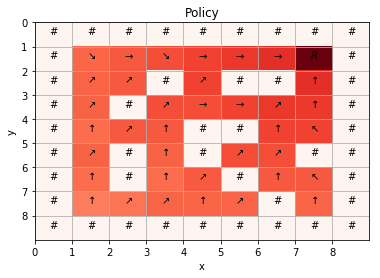

In [160]:
def plot_policy(env, agent, cfg, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.set_aspect("equal")
    
    # Handy variables
    maze_countours = maze.env.maze.matrix
    max_x = maze.env.maze.max_x
    max_y = maze.env.maze.max_y
    
    fitness_matrix = build_fitness_matrix(maze, agent.population, cfg)
    action_matrix = build_action_matrix(maze, agent.population, cfg)
    
    # Render maze as image
    plt.imshow(fitness_matrix, interpolation='nearest', cmap='Reds', aspect='auto',
           extent=[0, max_x, max_y, 0])
    
    
    # Add labels to each cell
    for (y,x), val in np.ndenumerate(action_matrix):
        plt.text(x+0.4, y+0.5, "${}$".format(val))
    
    ax.set_title("Policy")
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax.set_xlim(0, max_x)
    ax.set_ylim(max_y, 0)
    
    ax.set_xticks(range(0, max_x))
    ax.set_yticks(range(0, max_y))
    
    ax.grid(True)

plot_policy(maze, agent, cfg)
plt.savefig('maze_policy.eps', format='eps', dpi=100)

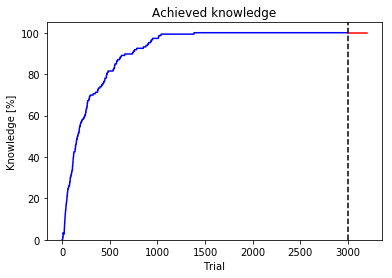

In [161]:
def plot_knowledge(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
        
    explore_df['knowledge'].plot(ax=ax, c='blue')
    exploit_df['knowledge'].plot(ax=ax, c='red')
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
        
    ax.set_title("Achieved knowledge")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Knowledge [%]")
    ax.set_ylim([0, 105])

plot_knowledge(metrics_df)
plt.savefig('maze_knowledge.eps', format='eps', dpi=100)

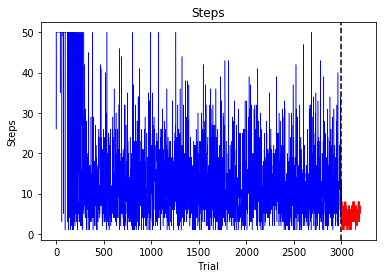

In [162]:
def plot_steps(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
    
    explore_df['steps'].plot(ax=ax, c='blue', linewidth=.5)
    exploit_df['steps'].plot(ax=ax, c='red', linewidth=0.5)
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
    
    ax.set_title("Steps")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Steps")
    
plot_steps(metrics_df)
plt.savefig('maze_steps.eps', format='eps', dpi=100)

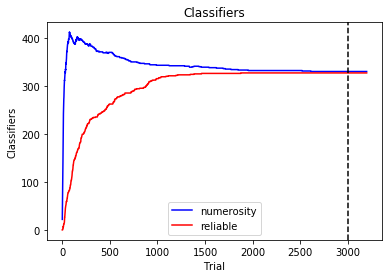

In [163]:
def plot_classifiers(df, ax=None):
    if ax is None:
        ax = plt.gca()
    
    explore_df = df.query("phase == 'explore'")
    exploit_df = df.query("phase == 'exploit'")
    
    df['numerosity'].plot(ax=ax, c='blue')
    df['reliable'].plot(ax=ax, c='red')    
    
    ax.axvline(x=len(explore_df), c='black', linestyle='dashed')
    
    ax.set_title("Classifiers")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Classifiers")
    ax.legend()

plot_classifiers(metrics_df)
plt.savefig('maze_classifiers.eps', format='eps', dpi=100)

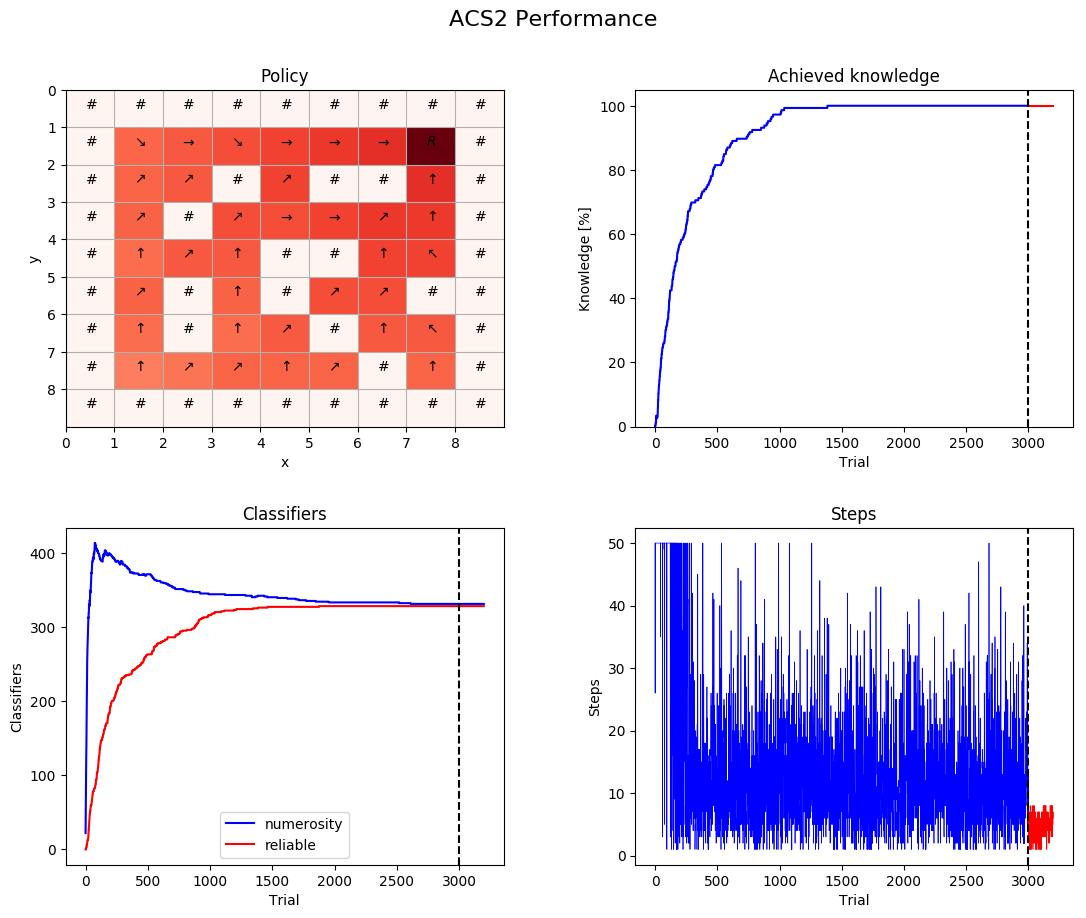

In [153]:
def plot_performance(agent, maze, metrics_df):
    plt.figure(figsize=(13, 10), dpi=100)
    plt.suptitle('ACS2 Performance', fontsize=16)
    
    ax1 = plt.subplot(221)
    plot_policy(maze, agent, ax1)
    
    ax2 = plt.subplot(222)
    plot_knowledge(metrics_df, ax2)
    
    ax3 = plt.subplot(223)
    plot_classifiers(metrics_df, ax3)
    
    ax4 = plt.subplot(224)
    plot_steps(metrics_df, ax4)
    
    plt.subplots_adjust(top=0.9, wspace=0.3, hspace=0.3)
    plt.show()

plot_performance(agent, maze, metrics_df)